In [192]:
# In this task we perform and implement prototypes of 3 algorithms used for threat detection
# 1. Average packets
# 2. Port Scanning
# 3. Frequency Analysis
# The assumptions used in each algorithm are outlined in their descriptions.

LOG_PATH = "../log/http.log"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from pylab import *
from scipy.fftpack import fft, fftfreq

In [17]:
"""
Reference: http://gauss.ececs.uc.edu/Courses/c6055/pdf/bro_log_vars.pdf
"""

names = ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'id.trans_depth', 'method', 
         'host', 'uri', 'referrer', 'user_agent', 'request_body_len', 'response_body_len', 'status_code',
         'status_msg', 'info_code', 'info_msg', 'filename', 'tags', 'username', 'password', 'proxied',
         'orig_fuids', 'orig_mime_types', 'resp_fuids', 'resp_mime_types']

In [9]:
df = pd.read_csv(LOG_PATH, sep = "\\t", engine = 'python', header = None, names = names)
df.tail()
        

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,id.trans_depth,method,host,uri,...,info_msg,filename,tags,username,password,proxied,orig_fuids,orig_mime_types,resp_fuids,resp_mime_types
2048437,1.332017e+09,CAfsIz2A8Xu5WbUXK8,192.168.202.87,44974,192.168.201.2,80,10,POST,192.168.201.2,/reporting/generateReport.php,...,-,-,(empty),-,-,-,F56aWQ2fj0GIeiEAja,text/plain,F3NLO522BrxzbzGdt5,text/html
2048438,1.332017e+09,CzyNKg1x0ufzurDE6f,192.168.202.87,44975,192.168.201.2,80,1,POST,192.168.201.2,/flagsubmission/getHandleInfo.php,...,-,-,(empty),-,-,-,F7WFOD3BY7HbV8KjX3,text/plain,FuzeP9PNt0qr85Ib2,text/html
2048439,1.332017e+09,CzyNKg1x0ufzurDE6f,192.168.202.87,44975,192.168.201.2,80,2,POST,192.168.201.2,/reporting/generateReport.php,...,-,-,(empty),-,-,-,FFbfyC2hSnNrUOKtSa,text/plain,FqI5OD2cvTjws3VMd,text/html
2048440,1.332017e+09,CzyNKg1x0ufzurDE6f,192.168.202.87,44975,192.168.201.2,80,3,POST,192.168.201.2,/flagsubmission/getHandleInfo.php,...,-,-,(empty),-,-,-,FH8qsC1rQAFZJHfnAc,text/plain,FupI2p4JEuUGrdlK25,text/html
2048441,1.332017e+09,CzyNKg1x0ufzurDE6f,192.168.202.87,44975,192.168.201.2,80,4,POST,192.168.201.2,/reporting/generateReport.php,...,-,-,(empty),-,-,-,FfrmnO2FQmr9ha1HK2,text/plain,FMFblO2dIdqHPs1S29,text/html


In [7]:
# some of the types don't really match up with the documentation
df.dtypes

ts                   float64
uid                   object
id.orig_h             object
id.orig_p              int64
id.resp_h             object
id.resp_p              int64
id.trans_depth         int64
method                object
host                  object
uri                   object
referrer              object
user_agent            object
request_body_len       int64
response_body_len      int64
status_code           object
status_msg            object
info_code             object
info_msg              object
filename              object
tags                  object
username              object
password              object
proxied               object
orig_fuids            object
orig_mime_types       object
resp_fuids            object
resp_mime_types       object
dtype: object

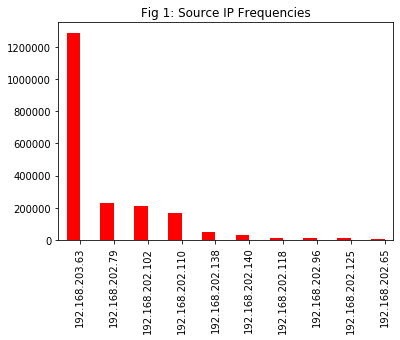

In [57]:
# here we perform some basic visualizations to get a sense of the data
# find unusually high request counts by IP
# can indicate attempted denial of service or host trying to check for open TCP ports
# We implement the denial of service detection, but it seems the port scanning attack is not within the
# scope of this dataset since the destination ports are limited to the following:
# [80, 5357, 5488, 8080, 8000, 1337, 3128, 8834]
df['id.orig_h'].value_counts()[:10].plot.bar(width = 0.4, position = 1, color = 'red', title = 'Fig 1: Source IP Frequencies')


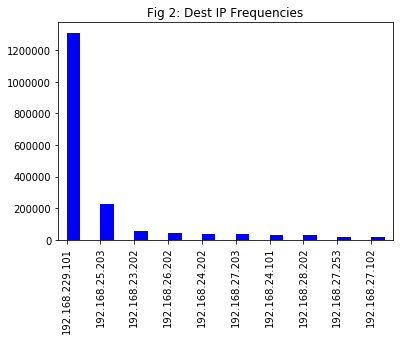

In [59]:
# check for IPs receiving the largest number of requests
# useful for detecting distributed attacks or perhaps detecting a C2 host which is receiving messages
# from a worm once it has successfully assumed control of a new device.
df['id.resp_h'].value_counts()[:10].plot.bar(width = 0.4, position = 0, color = 'blue', title = 'Fig 2: Dest IP Frequencies')

In [76]:
# EXPERIMENT 1: Denial of Service
# Nature of attack: Assessing web server's ability to respond to large quantities of requests
# from a single host.
# We can simply output the IPs where the number of requests exceed a certain threshold 
# (in terms of requests per unit time), but we can do better. Let's take a look at the nature of these
# requests. Specifically, we focus first on the source IP which issued the most number of requests observed.
# We assume that the attacks are not distributed in this case - they're all carried out by the same src.

tdf = df[df['id.orig_h'] == '192.168.203.63']
print("Total requests:", tdf.shape) # we check the number of requests being made by this IP address
print("Unique dest ports", tdf['id.resp_p'].unique()) # number of dest ports - here it's just 80 so they're all http requests
print("Timestamp range:", tdf['ts'].max()-tdf['ts'].min()) # timestamp range (in seconds)

print("Avg. Requests per second:", tdf.shape[0]/(tdf['ts'].max()-tdf['ts'].min()))
# We observe that on average, this IP address makes 72 queries a second over the course of ~5 hours.

Total requests: (1289498, 27)
Unique dest ports [80]
Timestamp range: 17822.819999933243
Avg. Requests per second: 72.35095231870321


In [96]:
# SAMPLE IMPLEMENTATION
# Based on experiment 1
# We perform this analysis for all IPs (which send a certain threshold number of requests)
TOTAL_REQ_THRESHOLD = 2000
REQ_PER_SEC_THRESHOLD = 5.0

graylist_1 = []
for src, freq in df['id.orig_h'].value_counts().items():
    if freq > TOTAL_REQ_THRESHOLD:
        tdf = df[df['id.orig_h'] == src]
        if tdf.shape[0]/(tdf['ts'].max() - tdf['ts'].min()) > REQ_PER_SEC_THRESHOLD:
            graylist_1.append({'src_ip': src, 
                             'total_req': tdf.shape[0], 
                             'avg_req_per_sec': tdf.shape[0]/(tdf['ts'].max() - tdf['ts'].min())})
print(graylist_1)

[{'src_ip': '192.168.203.63', 'total_req': 1289498, 'avg_req_per_sec': 72.35095231870321}, {'src_ip': '192.168.202.110', 'total_req': 169126, 'avg_req_per_sec': 5.2968156656409775}]


In [92]:
# EXPERIMENT 2: Port Scanning and known attacks correlated to ports
# Nature of Attack: An attacker may wish to find open TCP ports, or to try their luck with port knocking.
# This analysis is performed by finding which IP addresses make requests to a large number of different ports.
print("unique ports:", df['id.resp_p'].unique())

# Some research shows that a certain number of ports have been known to be used by malicious attackers.
# For instance: port 8834 is commonly used by Nessus web, an application used to discover network
# vulnerabilities. To find IPs which are utilizing this port:
print("IPs targeting port 8834:\n",df[df['id.resp_p'] == 8834]['id.orig_h'].value_counts())
    
# We observe that 192.168.204.45 is targeting this port, and has issued two requests. We may want to add
# this IP to the graylist for further study.

unique ports: [  80 5357 5488 8080 8000 1337 3128 8834]
IPs targeting port 8834:
 192.168.204.45    2
Name: id.orig_h, dtype: int64


In [97]:
# SAMPLE IMPLEMENTATION
# Based on experiment 2
# We perform this same analysis by constructing port filter rules for the following ports
# 1337: Used by the trojan Shadyshell (According to SANS)
# 3128: Used by several threats and trojans including RingZero, Mydoom and Deadhat
# 8834: As above.
# We assume that we have a list of ports which are known to be vulnerable and are "easy targets"
# for attackers, which can be used for running this form of analysis
GRAYLIST_PORTS = [1337, 3128, 8834]

graylist_2 = []
for port in GRAYLIST_PORTS:
    for src, freq in df[df['id.resp_p'] == port]['id.orig_h'].value_counts().items():
        graylist_2.append({'src_ip': src, 'total_req': freq, 'target_port': port})

print(graylist_2)

[{'src_ip': '192.168.202.112', 'total_req': 1, 'target_port': 1337}, {'src_ip': '192.168.202.110', 'total_req': 1, 'target_port': 1337}, {'src_ip': '192.168.202.110', 'total_req': 12593, 'target_port': 3128}, {'src_ip': '192.168.202.138', 'total_req': 7381, 'target_port': 3128}, {'src_ip': '192.168.202.140', 'total_req': 2434, 'target_port': 3128}, {'src_ip': '192.168.202.68', 'total_req': 230, 'target_port': 3128}, {'src_ip': '192.168.202.112', 'total_req': 50, 'target_port': 3128}, {'src_ip': '192.168.202.79', 'total_req': 35, 'target_port': 3128}, {'src_ip': '192.168.202.108', 'total_req': 24, 'target_port': 3128}, {'src_ip': '192.168.204.45', 'total_req': 18, 'target_port': 3128}, {'src_ip': '192.168.202.90', 'total_req': 11, 'target_port': 3128}, {'src_ip': '192.168.202.4', 'total_req': 8, 'target_port': 3128}, {'src_ip': '2001:dbb:c18:202:20c:29ff:fe93:571e', 'total_req': 5, 'target_port': 3128}, {'src_ip': '192.168.203.45', 'total_req': 4, 'target_port': 3128}, {'src_ip': '192.1

In [139]:
# Experiment 3 - a proof of concept: 
# We attempt to perform periodic beaconing detection by finding IPs which send
# large quantities of requests at fixed intervals. In this experiment we utilize the request volume as
# a proof of concept, but it is easily extendible to aggregating the request payload sizes, or sum of
# payload responses to this host. In this case, we select the host which sent out the most requests,
# in hopes to find some sort of pattern. To do this, we count the number of requests in every time window
# of fixed length, then perform a fourier transform to find a pattern in request frequency.

tdf = df[df['id.orig_h'] == '192.168.203.63']

"""
tdf['ts'] = pd.to_datetime(tdf['ts'], unit = 's', origin = 'unix')
tdf = tdf.set_index('ts')
tdf.resample("30S").pad() # resampling doesn't work - some weird reindexing error
tdf.rolling('30s') # this doesn't work either - known issue with using rolling function with timedelta windows
"""

'\ntdf[\'ts\'] = pd.to_datetime(tdf[\'ts\'], unit = \'s\', origin = \'unix\')\ntdf = tdf.set_index(\'ts\')\ntdf.resample("30S").pad() # resampling doesn\'t work some weird reindexing error\ntdf.rolling(\'30s\') # this doesn\'t work either - known issue with using rolling function\n'

In [167]:
# convert to rolling window here (but the builtin functions are broken so we make our own)
# this is really slow processing maybe a million entries a minute because it's linear, but can be
# sped up using a binary tree or something (the rolling function in pandas supposedly does this)
WINDOW_SIZE_SECONDS = 30

def get_rolling(df, window):
    # window is in seconds
    df = df.sort_values('ts')
    min_time = df.iloc[0]['ts']
    max_time = df.iloc[-1]['ts']
    windows = []
    cur_time = min_time
    cur_time_count = 0
    i = 0
    while True:
        if i >= df.shape[0]:
            break
        
        if i%100000 == 0:
            print("Processed {} of {} entries".format(i, df.shape[0]))
            
        r = df.iloc[i]
        if r['ts'] < cur_time + 30:
            cur_time_count += 1
            i += 1
            
        else:
            windows.append([cur_time, cur_time_count])
            cur_time += 30
            cur_time_count = 0
    
    print("done")
    return windows

# get request volume over time windows of 30 seconds.
freq = get_rolling(tdf, WINDOW_SIZE_SECONDS)

Processed 0 of 1289498 entries
Processed 100000 of 1289498 entries
Processed 200000 of 1289498 entries
Processed 300000 of 1289498 entries
Processed 400000 of 1289498 entries
Processed 500000 of 1289498 entries
Processed 600000 of 1289498 entries
Processed 700000 of 1289498 entries
Processed 800000 of 1289498 entries
Processed 900000 of 1289498 entries
Processed 1000000 of 1289498 entries
Processed 1100000 of 1289498 entries
Processed 1200000 of 1289498 entries
done


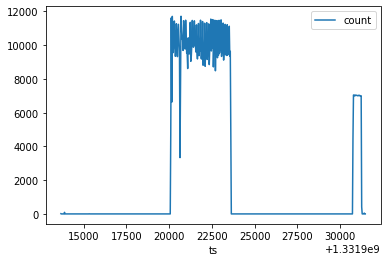

In [155]:
# we plot the requests against time here, and notice there are bursts of time where the requests
# come in at once. We can infer that there is no observable pattern here.
freq_df = pd.DataFrame(freq, columns = ['ts', 'count'])
freq_df = freq_df.set_index('ts')
freq_df.plot()

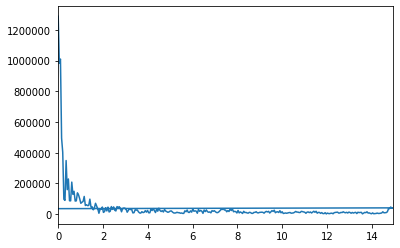

In [186]:
# Do fourier transform to find the frequency of requests coming in.
# We can then filter by the power of the frequency vector, and graylist IPs which have
# the power of one or more frequencies (greater than a threshold) exceeding some amount.
# I'm not entirely sure about the mathematics behind how this works since I have not formally studied
# fourier transforms - I'm just aware that this will allow us to identify the periodicity
# of the requests which are being made. For instance, in the graph below, it seems that there is no real
# pattern for this particular IP, as expected. 
# If a threshold was set without a minimum frequency, then this IP would be
# graylisted. However, with a minimum frequency such as once every 3 minutes, this particular IP
# would not be flagged as a possible IOC for periodic beaconing, since there does not exist a frequency
# greater than 3 where a significant power is observed.
FFT = abs(fft(freq_df['count']))
freqs = fftfreq(freq_df.shape[0], 1/WINDOW_SIZE_SECONDS)
xlim(0,max(freqs))
plot(freqs, FFT)

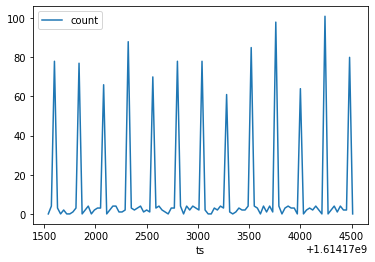

In [199]:
# To test the robustness of this experiment, let's simulate a host where periodic beaconing is taking place
TEST_WINDOW_SIZE = 30.0
BASE_TIMESTAMP = 1614171541.0

np.random.seed(int(time.time()))

test_freq = []
for i in range(100):
    ts = BASE_TIMESTAMP + i * TEST_WINDOW_SIZE
    test_freq.append([ts, np.random.randint(low = 0, high = 5) 
                      + (np.random.randint(low = 60, high = 100) if i % 8 == 2 else 0)]) # every 4 minutes

test_freq_df = pd.DataFrame(test_freq, columns = ['ts', 'count'])
test_freq_df = test_freq_df.set_index('ts')
test_freq_df.plot()

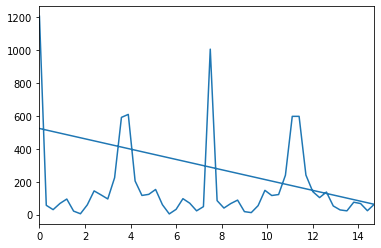

In [249]:
TEST_FFT = abs(fft(test_freq_df['count']))
test_freqs = fftfreq(test_freq_df.shape[0], 1/TEST_WINDOW_SIZE)
xlim(0,max(test_freqs))
plot(test_freqs, TEST_FFT)

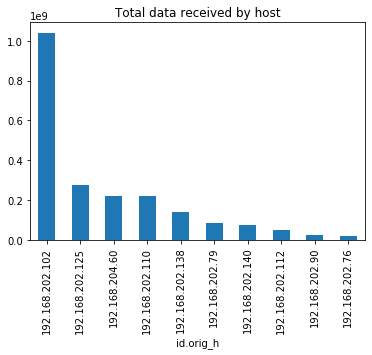

In [245]:
# IMPLEMENTATION
# Based on experiment 3.
# Let's apply this to find IPs which request large quantities of data every time period, to find
# attackers who may be periodically exfiltrating data from a web server. In this case, we sum the payload
# sizes of the data being sent to a host. We make the assumption that the attacker exfils the data to 
# the same destination IP address (not distributed).
# Periodic exfiltration may occur to prevent tripping network monitoring tools which detect a sudden
# massive surge in data being sent from the web server, by spacing out the transfers.
WINDOW_SIZE = 30 # seconds
TOTAL_VOLUME_THRESHOLD = 10000000 # 10 million bytes
MIN_FREQ_THRESHOLD = 4 # in multiples of window size
MIN_POWER_THRESHOLD = 1e8 # minimum amplitude of a frequency to graylist

tdf = df.groupby('id.orig_h')['response_body_len'].sum()
tdf = tdf.sort_values(ascending = False)
tdf[:10].plot.bar(title = "Total data received by host") # test
# tdf['response_body_len']


In [226]:
# Create window function for response body length aggregation against time
def get_rolling_length(df, window):
    print("Generating rolling window for {}".format(df.iloc[0]['id.orig_h']))
    # window is in seconds
    df = df.sort_values('ts')
    min_time = df.iloc[0]['ts']
    max_time = df.iloc[-1]['ts']
    windows = []
    cur_time = min_time
    cur_time_size = 0
    i = 0
    while True:
        if i >= df.shape[0]:
            break
        
        if i%100000 == 0:
            print("Processed {} of {} entries".format(i, df.shape[0]))
            
        r = df.iloc[i]
        if r['ts'] < cur_time + 30:
            cur_time_size += r['response_body_len']
            i += 1
            
        else:
            windows.append([cur_time, cur_time_size])
            cur_time += 30
            cur_time_size = 0
    
    print("done")
    return windows

In [248]:
graylist_3 = []
for k, v in tdf.items():
    if v > TOTAL_VOLUME_THRESHOLD:
        vdf = df[df['id.orig_h'] == k]
        windows = get_rolling_length(vdf, WINDOW_SIZE)
        windows_df = pd.DataFrame(windows, columns = ['ts', 'volume'])
        windows_df = windows_df.set_index('ts')
        FFT = abs(fft(windows_df['volume']))
        freqs = fftfreq(windows_df.shape[0], 1/WINDOW_SIZE)
        flag = False
        for x, y in zip(freqs, FFT):
            if x >= MIN_FREQ_THRESHOLD and y > MIN_POWER_THRESHOLD:
                flag = True
                
        if flag:
            graylist_3.append({'src_ip': k, 'total_req_volume': v})
    
print(graylist_3)

Generating rolling window for 192.168.202.102
Processed 0 of 212234 entries
Processed 100000 of 212234 entries
Processed 200000 of 212234 entries
done
Generating rolling window for 192.168.202.125
Processed 0 of 8794 entries
done
Generating rolling window for 192.168.204.60
Processed 0 of 22 entries
done
Generating rolling window for 192.168.202.110
Processed 0 of 169126 entries
Processed 100000 of 169126 entries
done
Generating rolling window for 192.168.202.138
Processed 0 of 47379 entries
done
Generating rolling window for 192.168.202.79
Processed 0 of 232259 entries
Processed 100000 of 232259 entries
Processed 200000 of 232259 entries
done
Generating rolling window for 192.168.202.140
Processed 0 of 28332 entries
done
Generating rolling window for 192.168.202.112
Processed 0 of 5631 entries
done
Generating rolling window for 192.168.202.90
Processed 0 of 1750 entries
done
Generating rolling window for 192.168.202.76
Processed 0 of 4497 entries
done
Generating rolling window for 192